## Packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime as dat
import pickle
import re
# from pathlib import Path

# from google.colab import data_table
# data_table.enable_dataframe_formatter()

# preprocessing tool
import sklearn
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler

# modeling tool
from sklearn.model_selection import train_test_split
# from sklearn.cluster import KMeans 
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

# font1 = {'family':'serif','color':'blue','size':30}
# font2 = {'family':'serif','color':'darkred','size':30}
# font2 = {'family':'serif','color':'red','size':30}

## HELPER FUNCTIONS 
To extract flow metrics from traffic flow data and for the modeling

In [3]:
def extract_tcp_flag(n):
  pattern = r"\d\[\w*\W*\w*]|\W\[\w*\W*\w*]"
  pattern2 = r"[A-Z]{3}"
  a = ''.join(re.split("\s", n))
  b = re.findall(pattern, a)
  return ''.join(re.findall(pattern2, b[0])) if b else 'NONE'

def my_fun(x):
    return x.iloc[-1] - x.iloc[0]

def make_flow_data(df):
    'extranct flow metric from traffic data'  

    flow_dt = {'pkt_start':[], 'pkt_end':[], 'flow_period':[], 'average_pack_time':[],
               'prot_type':[], 'av_pl':[], 'av_sn':[], 'no_tcp_flags':[], 'tcp_flags':[], 
               'count_tcp':[], 'count_icmp':[], 'count_udp':[],
               'unique_prot':[]
              }
    flow_id = 1
    start = 0
    roller = 5
    step = 5
    for r in range(0, len(df), step):
        if (r+roller > len(df)): 
    #         print (start, ':', len(df))
            flow_dt['pkt_start'].append(start)
            flow_dt['pkt_end'].append(len(df))
            rolling_df = df[start:end]
        else :
            if r == 0:
                continue 
            else:
                end = r+roller
    #             print(start, ':', r+roller)
                rolling_df = df[start:end]
                flow_dt['pkt_start'].append(start)
                flow_dt['pkt_end'].append(end)
                #rolling_df

        # transform the data
        t_rolling_df = rolling_df
        TCP_flags = list(map(extract_tcp_flag, t_rolling_df.Info))
        TCP_flags = ''.join(set(TCP_flags))                 #+++++++++++++++++++
#         if np.nan in TCP_flags: TCP_flags.remove(np.nan)         #+++++++++++++++++++               
        if not(TCP_flags): TCP_flags = 'NONE'         #+++++++++++++++++++

        #   populate data    
        flow_dt['prot_type'].append(''.join(set(t_rolling_df.Protocol)))   #+++++++++++++++++++
        flow_dt['av_pl'].append(t_rolling_df.Length.mean())         
        try: 
            flow_dt['av_sn'].append(np.mean([float(item) for item in t_rolling_df["Sequence number"]]))
        except:
            flow_dt['av_sn'].append('None')
        flow_dt['tcp_flags'].append(TCP_flags)  #+++++++++++++++++++
        flow_dt['no_tcp_flags'].append(len(TCP_flags))
        flow_dt['flow_period'].append(list(t_rolling_df.Time)[-1] - list(t_rolling_df.Time)[0])
        flow_dt['average_pack_time'].append(t_rolling_df.Time[:5].rolling(window=2).apply(my_fun).mean())
        flow_dt['count_icmp'].append(t_rolling_df[t_rolling_df.Protocol=='ICMP'].Protocol.count())
        flow_dt['count_udp'].append(t_rolling_df[t_rolling_df.Protocol=='UDP'].Protocol.count())
        flow_dt['count_tcp'].append(t_rolling_df[t_rolling_df.Protocol=='TCP'].Protocol.count())  
        flow_dt['unique_prot'].append(len(t_rolling_df.Protocol.unique()))
        
#         print(f'{df.name.unique()[0]} Done with Flow', flow_id)
        start = r
        flow_id+= 1
    return pd.DataFrame.from_dict(flow_dt).iloc[:,0:]

#  PREPROCESSING (one hot encoding using pandas)
def hot_encode_data (X):
    X_prot = pd.get_dummies(X.prot_type, prefix='protl', drop_first=True)
    X_flags = pd.get_dummies(X.tcp_flags, prefix='flags', drop_first=True)
    X_dt = X.drop(columns = ['prot_type','tcp_flags'])
    X_dt = pd.concat([X_dt, X_prot, X_flags], axis=1)
    return X_dt

def label_encode_data (X):
#     X_dt = X.drop(columns = ['prot_type','tcp_flags'])
    prot_type_le = LabelEncoder().fit(X.prot_type)
    tcp_flags_le = LabelEncoder().fit(X.tcp_flags)
    X['prot_type'] = prot_type_le.transform(X.prot_type)
    X['tcp_flags'] = tcp_flags_le.transform(X.tcp_flags)
    return X

def scale_encoded_data (encoded_data, scaler):       
    scaled_X = scaler.transform(encoded_data) 
    return pd.DataFrame(scaled_X, columns=encoded_data.columns)

# MODEL EVALUATION
def print_model_eval (y_true, y_pred):    
    accuracy = sklearn.metrics.accuracy_score
    b_accuracy = sklearn.metrics.balanced_accuracy_score
    print('='*50)
    print('Accuracy: ', accuracy(y_true, y_pred))  
    print('Balance Accuracy: ', b_accuracy(y_true, y_pred))
    print('='*50)

# VISUALIZATION
def get_pca (df, scale=True): 
    pca = sklearn.decomposition.PCA(n_components=2)
    pipe = Pipeline([('scaler', StandardScaler()), ('pca', pca)]) if scale else Pipeline([('pca', pca)])
    pca_df = pipe.fit_transform(df)
    print('PCA explained variance ratio:', pca.explained_variance_ratio_)
    return pca_df
                     
# Predicted label visualisation
def plot_pred_label (pca_data, y_pred, title = 'one-hot'):
    plot = sns.scatterplot(x = pca_data[:,0], y = pca_data[:,1], 
                    hue=y_pred, alpha=None, 
                    palette= "tab10"
                   )
    plot.set(title = f"Predicted label visualisation ({title})")
    plt.show() 

# True label visualisation
def plot_true_label (pca_data, y_true, title = 'one-hot'):
    plot = sns.scatterplot(x = pca_data[:,0], y = pca_data[:,1], 
                    hue=y_true, alpha=None, 
                    palette= "tab10"
                   )
    plot.set(title = f"True label visualisation ({title})")
    plt.show()

## modeling

#### Kmeans

In [ ]:
flow_data = pd.read_csv('../data/Training_flow_data.csv').iloc[:,1:]
# flow_data.query('label != "benignprivate"').head()   # non benign data
# for n in flow_data.columns:
#     u = flow_data[n].unique()
#     if 'None' in u:
#         print(n, ':', u)
# flow_data.isna().sum()
# flow_data

# # Preprocess data
y_true = flow_data['label']
X = flow_data.drop(columns = ['pkt_start','pkt_end', 'label'])  # drop dummy column and the actual label 
# X = flow_data.drop(columns = ['Unnamed: 0','label'])  # drop dummy column and the actual label 
X['av_sn'].replace([np.nan,'None'], -1, inplace=True)   # encode flows with no average sequece number (nan/'None') with -1
print(X.isna().sum())

# print(len(flow_data.query('label != "benignprivate"')) )  # non benign data
# print(len(flow_data.query('label != "TCPSYNprivate"')) )  # non benign data
# print(len(flow_data.query('label != "ICMPprivate"')) )  # non benign data
# print(len(flow_data.query('label != "UDPprivate"')) )  # non benign data

In [ ]:
# encode data
X_hot = hot_encode_data (X)

# create scaler and scale encoded data
scaler = StandardScaler().fit(X_hot)  
pickle.dump(scaler, open('scaler_hot', 'wb'))  # for use during prediction 
X_hot = scaler_encoded_data(X_hot, scaler)


# modeling
kmeans = KMeans(n_clusters=4, random_state=10).fit(X_hot)
flow_data['label_kmeans_hot'] = kmeans.labels_
hot_map = {3:'ICMPprivate', 2:'TCPSYNprivate', 0:'UDPprivate', 1:'benignprivate'} # Label mapping
y_pred = flow_data['label_kmeans_hot'].replace(hot_map) 

# evaluate model
print_model_eval(flow_data['label'], y_pred)

# visualisation
pca_hot = get_pca(X_hot) # PCA
plot_pred_label (pca_hot, y_pred) # predicted label
plot_true_label(pca_hot, y_true)  # true label

# save model
pickle.dump(kmeans, open('kmeans_model', 'wb'))          

In [ ]:
# encode data
X_le = label_encode_data (X)

# create scaler and scale encoded data
scaler = StandardScaler().fit(X_le)  
pickle.dump(scaler, open('scaler_le', 'wb'))  # for use during prediction 
X_le = scaler_encoded_data(X_le, scaler)

# modeling
kmeans = KMeans(n_clusters=4, random_state=10).fit(X_le)
flow_data['label_kmeans_le'] = kmeans.labels_
le_map = {1:'ICMPprivate', 0:'TCPSYNprivate', 3:'UDPprivate', 2:'benignprivate'} # Label mapping
y_pred = flow_data['label_kmeans_le'].replace(le_map)


# evaluate model
print_model_eval(flow_data['label'], y_pred)

# visualiozation
pca_le = get_pca(X_le) # PCA
plot_pred_label (pca_le, y_pred, title = 'Label-encoding') # predicted label
plot_true_label(pca_le, y_true, 'Label-encoding')  # true label

# save model
pickle.dump(kmeans, open('kmeans_le_model', 'wb'))  

#### Detection

In [ ]:
# load the model from disk 
# loaded_model = pickle.load(open('kmeans_model', 'rb'))
# hot_map = {2:'ICMPprivate', 3:'TCPSYNprivate', 0:'UDPprivate', 1:'benignprivate'} # Label mapping
loaded_model = pickle.load(open('kmeans_le_model', 'rb'))
le_map = {0:'ICMPprivate', 1:'TCPSYNprivate', 2:'UDPprivate', 3:'benignprivate'} # Label mapping


# Read the data (modeling - get traffic data)
traffic_df =  pd.read_csv('../data/deploy data/DDoS UDPPRIVATE.csv') # Read in data
traffic_df = traffic_df[:20]
# # Extract flow data  
flow_df = make_flow_df(traffic_df) 

# # preprocess for modeling
feature = flow_df.drop(columns = ['pkt_start','pkt_end'])  # drop dummy column and the actual label 
feature['av_sn'].replace([np.nan,'None'], -1, inplace=True)   # encode flows with no average sequece number (nan/'None') with -1

# # encode data
# X = hot_encode_data (X)
feature = label_encode_data(feature)
scaler = pickle.load(open('scaler_le', 'rb')) # saved during training
feature = scaler_encoded_data(feature, scaler)            
packet_info = flow_df.loc[:,['pkt_start','pkt_end']]

# modeling (predict) 
for i in range(len(feature)):
    d = feature.loc[[i]]
    pred = loaded_model.predict(d)[0]
    if pred != 3:
        print(f'"{le_map[pred]}" Attack detected @packet end "{packet_info.pkt_end[i]}" - stop server NOW')
        break
    else:
        print('Pass')

## Random Forest

### Modeling

Accuracy:  1.0
Balance Accuracy:  1.0
PCA explained variance ratio: [0.38112469 0.28849584]


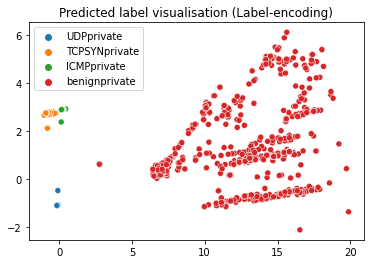

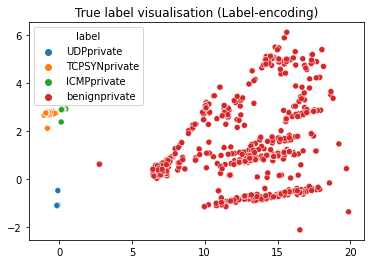

In [26]:
#1 read in flow data ------->flow_df = make_flow_data(training_traffic_df)
flow_data = pd.read_csv('../data/Training_flow_data.csv').iloc[:,1:]

def make_attack_model (flow_data, scale=False, plot_eval=True):
    #2 Preprocess data
    y = flow_data['label']
    X = flow_data.drop(columns = ['pkt_start','pkt_end', 'label'])  # drop dummy column and the actual label 
    X['av_sn'].replace([np.nan,'None'], -1, inplace=True)   # encode flows with no average sequece number (nan/'None') with -1

    #3 encode data
    X = label_encode_data (X)
    # unique_prot_type = list(set(X['prot_type']))
    # unique_tcp_flags = list(set(X['tcp_flags']))
    # unique_prot_type.append('Unseen')
    # unique_tcp_flags.append('Unseen')
    # prot_type_le = LabelEncoder().fit(unique_prot_type)
    # tcp_flags_le = LabelEncoder().fit(unique_tcp_flags)
    # pickle.dump(prot_type_le, open('models/prot_type_le', 'wb'))  # for use during prediction 
    # pickle.dump(tcp_flags_le, open('models/tcp_flags_le', 'wb'))  # for use during prediction 
    # X['prot_type'] = prot_type_le.transform(X.prot_type)
    # X['tcp_flags'] = tcp_flags_le.transform(X.tcp_flags)

    #4 create scaler and scale encoded data
    scaler = StandardScaler().fit(X)  
    if scale: 
        X = scale_encoded_data(X, scaler)

    #5 modeling
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=10, shuffle=True, stratify=y)
    model = RandomForestClassifier(random_state=10).fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # evaluate model
    print_model_eval(y_test, y_pred)
    if plot_eval:
        # visualiozation
        pca_le = get_pca(X_test, scale=False) if scale else get_pca(X_test) # PCA
        plot_pred_label (pca_le, y_pred, title = 'Label-encoding') # predicted label
        plot_true_label(pca_le, y_test, 'Label-encoding')  # true label
        
    return model, scaler

model, scaler = make_attack_model(flow_data, scale=True) # for use during prediction 

# save model and scaler 
pickle.dump(scaler, open('models/scaler_le', 'wb'))  
pickle.dump(model, open('models/RF_le_model', 'wb')) 

### Detection

In [38]:
def attack_detector (df, loaded_model, scaler=None, scale = True, destination=None):
    'extract flow metric from traffic data'  
    
    if destination: df = df.query(f'Destination=="{destination}"')
    
#1  Extract flow data ------->flow_df = make_flow_data(traffic_df)
    flow_id = 1
    start = 0
    roller = 5
    step = 5
    for r in range(0, len(df), step):
        flow_dt = {'pkt_start':[], 'pkt_end':[], 'flow_period':[], 'average_pack_time':[],
               'prot_type':[], 'av_pl':[], 'av_sn':[], 'no_tcp_flags':[], 'tcp_flags':[], 
               'count_tcp':[], 'count_icmp':[], 'count_udp':[],
               'unique_prot':[]
              }
        if (r+roller > len(df)): 
            flow_dt['pkt_start'].append(start)
            flow_dt['pkt_end'].append(len(df))
            rolling_df = df[start:end]
        else :
            if r == 0:
                continue 
            else:
                end = r+roller
    #             print(start, ':', r+roller)
                rolling_df = df[start:end]
                flow_dt['pkt_start'].append(start)
                flow_dt['pkt_end'].append(end)
                #rolling_df

         # transform the data
        t_rolling_df = rolling_df
        TCP_flags = list(map(extract_tcp_flag, t_rolling_df.Info))
        TCP_flags = ''.join(set(TCP_flags))                 #+++++++++++++++++++
#         if np.nan in TCP_flags: TCP_flags.remove(np.nan)         #+++++++++++++++++++               
        if not(TCP_flags): TCP_flags = 'NONE'         #+++++++++++++++++++

        #   populate data    
        flow_dt['prot_type'].append(''.join(set(t_rolling_df.Protocol)))   #+++++++++++++++++++
        flow_dt['av_pl'].append(t_rolling_df.Length.mean())          
        try: 
            flow_dt['av_sn'].append(np.mean([float(item) for item in t_rolling_df["Sequence number"]]))
        except:
            flow_dt['av_sn'].append('None')
        flow_dt['tcp_flags'].append(str(TCP_flags))
        flow_dt['no_tcp_flags'].append(len(TCP_flags))
        flow_dt['flow_period'].append(list(t_rolling_df.Time)[-1] - list(t_rolling_df.Time)[0])
        flow_dt['average_pack_time'].append(t_rolling_df.Time[:5].rolling(window=2).apply(my_fun).mean())
        flow_dt['count_icmp'].append(t_rolling_df[t_rolling_df.Protocol=='ICMP'].Protocol.count())
        flow_dt['count_udp'].append(t_rolling_df[t_rolling_df.Protocol=='UDP'].Protocol.count())
        flow_dt['count_tcp'].append(t_rolling_df[t_rolling_df.Protocol=='TCP'].Protocol.count())  
        flow_dt['unique_prot'].append(len(t_rolling_df.Protocol.unique()))
        
        flow_df = pd.DataFrame.from_dict(flow_dt)
        print('='*10, f'flow {flow_id} : packet {start} -- packet {end}', '='*10)  ######################
#         print(flow_df) ##############################

#2      Preprocess the flow data
        feature = flow_df.drop(columns = ['pkt_start','pkt_end'])  # drop dummy column and the actual label 
        feature['av_sn'].replace([np.nan,'None'], -1, inplace=True)   # encode flows with no average sequece number (nan/'None') with -1

#3      # encode the flow data
        feature = label_encode_data(feature)
#         feature['prot_type'] = [x if x in prot_type_le.classes_ else 'Unseen' for x in feature['prot_type']]  # handle useen lebel
#         feature['tcp_flags'] = [x if x in tcp_flags_le.classes_ else 'Unseen' for x in feature['tcp_flags']]  # handle useen lebel
#         feature['prot_type'] = prot_type_le.transform(feature.prot_type)        
#         feature['tcp_flags'] = tcp_flags_le.transform(feature.tcp_flags)
        
#4      create scaler and scale the encoded data
        if scale:
            feature = scale_encoded_data(feature, scaler)
            
        packet_info = flow_df.loc[:,['pkt_start','pkt_end']]
#         print('='*50, )    ######################
#         print(feature)     ######################

#5      make prediction
        pred = loaded_model.predict(feature)[0]
#         print (pred)   ######################

#6      Take action based on prediction (traffic type)
        if pred != 'benignprivate':
            print( f'"{pred}" Attack detected between packet: {packet_info.pkt_start[0]} and {packet_info.pkt_end[0]} \n stop server NOW')
            break
        else:
            print('"Normal flow"')
#         print('='*50, f'flow {flow_id} : start {end}', '='*50)   ######################
        start = r
        flow_id+= 1

In [57]:
# load saved label_encoders, scaler, and model from disk (saved during training)
# prot_type_le = pickle.load(open('models/prot_type_le', 'rb')) 
# tcp_flags_le = pickle.load(open('models/tcp_flags_le', 'rb'))   
# scaler = pickle.load(open('models/scaler_le', 'rb'))
# rf_clf = pickle.load(open('models/RF_le_model', 'rb'))
scale=True
rf_clf, scaler = make_attack_model(flow_data, plot_eval=False, scale=scale) 


# Read the data (detection - get traffic data)
traffic_df = normal_df
traffic_df = public_normal_df
# traffic_df = public_ICMP
# traffic_df =  pd.read_csv('C:/Users/oluwasegun.apejoye/Downloads/J_data/deploy data/DDoS UDPPRIVATE.csv') # Read in data
# traffic_df =  pd.read_csv('C:/Users/oluwasegun.apejoye/Downloads/J_data/deploy data/DDoSICMPPRIVATE.csv') # Read in data
# traffic_df =  pd.read_csv('C:/Users/oluwasegun.apejoye/Downloads/J_data/deploy data/TCPSYN private.csv').query('Protocol != "ICMP"')
# traffic_df = traffic_df[:500]

# tcp_destination = "192.168.0.100"
# attack_detector(traffic_df, rf_clf, scaler,
#                 scale=scale, 
#                 destination=tcp_destination)
attack_detector(traffic_df, rf_clf, scaler, scale=scale)

Accuracy:  1.0
Balance Accuracy:  1.0


AttributeError: 'DataFrame' object has no attribute 'Info'

### Detection result 

#### No scaling in all phases (training and detection) => test = 100%
NORMAL: attack starts from packet no 0      ----> all normal

ICMP: attack starts from packet no 58       ----> "ICMPprivate" Attack detected between packet: 55 and 65 

UDP: attack starts from packet no 262       ----> "UDPprivate" Attack detected between packet: 265 and 275

_TCPSYN: attack starts from packet no 0      ----> all normal_

#### scaling in all phases (training and detection)   => test = 100%
NORMAL: attack starts from packet no 0      ----> all normal

ICMP: attack starts from packet no 58       ----> "ICMPprivate" Attack detected between packet: 55 and 65  

UDP: attack starts from packet no 262       ----> "UDPprivate" Attack detected between packet: 265 and 275 

_TCPSYN: attack starts from packet no 0      ----> all normal_




#### no scaling in only training phase =>  test = 100%
NORMAL: attack starts from packet no 0      ---->  "ICMPprivate" Attack detected between packet: 45 and 55 
ICMP: attack starts from packet no 58       ----> "ICMPprivate" Attack detected between packet: 5 and 15 
UDP: attack starts from packet no 262       ---->  "ICMPprivate" Attack detected between packet: 20 and 30 
TCPSYN: attack starts from packet no 0      ---->  "ICMPprivate" Attack detected between packet: 0 and 10 

#### no scaling in only dectection phase =>  test = 100%
NORMAL: attack starts from packet no 0      ----> all normal 
ICMP: attack starts from packet no 58       ----> all normal
UDP: attack starts from packet no 262       ---->  all normal
TCPSYN: attack starts from packet no 0      ----> all normal

## Testing codes

In [44]:
# # benignprivate 
# # TCPSYNprivate 
# # ICMPprivate 
# # UDPprivate 

# # X_dt['prot_type'] = LabelEncoder().fit_transform(X.prot_type)
# # X_dt['tcp_flags'] = LabelEncoder().fit_transform(X.tcp_flags)

# # Read the data (modeling - get traffic data)
# traffic_df =  pd.read_csv('../data/large_data/deploy data/DDoS UDPPRIVATE.csv') # Read in data
# # traffic_df =  pd.read_csv('../data/large_data/deploy data/DDoSICMPPRIVATE.csv') # Read in data
# # traffic_df =  pd.read_csv('../data/large_data/deploy data/TCPSYN private.csv').query('Protocol != "ICMP"')
# traffic_df = traffic_df[:1000]

# t_flow_data = flow_data#.query('label == "ICMPprivate"')
# d_flow_data = make_flow_data(traffic_df)
# print('Training tcp_flags: ', set(t_flow_data.tcp_flags))
# print('Training prot_type: ', set(t_flow_data.prot_type))
# print('Detection sample tcp_flags: ', set(d_flow_data.tcp_flags))
# print('*'*50)
# print ('New prot_type value(s): ', [x for x in set(d_flow_data.prot_type) if x not in set(t_flow_data.prot_type)])
# print ('New tcp_flags value(s): ', [x for x in set(d_flow_data.tcp_flags) if x not in set(t_flow_data.tcp_flags)])

Training tcp_flags:  {'RSTACKFINACKNONE', 'ACKPSHACKNONE', 'ACKNONE', 'ACKSYNACKNONE', 'ACKTCPACKNONE', 'SYN', 'ACKSYNACKFINACKNONE', 'NONE', 'ACK', 'ACKRSTACKNONE', 'ACKTCPNONE', 'ACKFINACKRSTACKNONE', 'RSTACKACKFINACKNONE', 'ACKFINACKNONE', 'ACKNONERSTACK', 'ACKSYNACKRSTNONE', 'ACKPSHACKSYNACKNONE', 'ACKFINACKRSTACKNONERST', 'ACKRSTNONE'}
Training prot_type:  {'DNSTCP', 'NTPTLSv1.2DNSTCP', 'TLSv1.2TCP', 'TCP', 'NTPTLSv1.2TCP', 'TLSv1.2TCPUDP', 'DNSTLSv1.2TCP', 'UDP', 'DNSTLSv1.2TCPUDP', 'ICMP'}
Detection sample tcp_flags:  {'FINACKSYNACKNONEACK', 'FINACKNONERSTACK', 'FINACKRSTNONEPSHACKACK', 'NONERST', 'SYNACKNONEPSHACKACK', 'NONEPSHACKACK', 'NONE', 'NONEACK', 'SYNACKNONEACK', 'FINACKNONE', 'FINACKSYNACKPSHACKACK', 'FINACKNONERST', 'FINACKNONEACK', 'ACK'}
**************************************************
New prot_type value(s):  ['TCPTLSv1.2', 'TLSv1.2', 'UDPICMPTLSv1.2', 'UDPICMP', 'UDPTLSv1.2', 'DNSTCPTLSv1.2']
New tcp_flags value(s):  ['FINACKSYNACKNONEACK', 'FINACKNONERSTACK', '

In [48]:
from pathlib import Path
# Unpickle all the file into 
datalist = []
# basepath = '/content/picked/'
# basepath = '/J_data/'
basepath = '../data/large_data/pickled'
for item in sorted(Path(basepath).iterdir()): 
    if item.is_file():  # filter out items that are directories
        with open(item, 'rb') as f:    # file to
          datalist.append(pickle.load(f))

[n.name[0] for n in datalist]   # view the arrangement of the files
# read all data
normal_df, public_normal_df, private_ICMP, public_ICMP, tcpsyn_df, public_tcpsyn_df, \
private_UDP, public_UDP = [d for d in datalist]

#### Extract flow data

In [60]:
# filter for traffics flowing into our device
filtered_normal_df = normal_df.query('Destination=="rcr-663.local"')#[:1000]
filtered_private_ICMP = private_ICMP.query('Destination=="192.168.0.104" & Source=="192.168.0.102"')
filtered_private_UDP = private_UDP.query('Destination=="192.168.0.104" & Source=="192.168.0.102"')
filtered_tcpsyn_df = tcpsyn_df.query(
    '(Source == "192.168.0.103" | Source == "ASHOK-DESKTOP.local") & Destination == "192.168.0.100" & Protocol != "ICMP"')

data = [filtered_normal_df, filtered_tcpsyn_df, 
        filtered_private_ICMP, filtered_private_UDP
       ]
all_flow_dt = pd.DataFrame()
for d in data:
    flow_data = make_flow_df(d)
    flow_data['label'] = d.name.unique()[0]
#     flow_data.to_csv(f'{d.name.values[0]}_flow.csv')
    all_flow_dt=pd.concat([all_flow_dt, flow_data], ignore_index=True)
    print(f'Done with {d.name.unique()[0]} ')    
    
all_flow_dt.to_csv('../data/Training_flow_data.csv')

,timestamp,src_ip,dst_ip,protocol,length,src_port,dst_port,flag,seq_no,ack_no,...,req_for,response_no,version,dns_query_response,tx_id,req_reply,ttl,req_resp_no,label,name
0,5.098458,137.3.161.0,172.16.0.248,DNS,70,NaN,NaN,NaN,NaN,NaN,...,test_query,NaN,NaN,Standard_query,0x4242,NaN,NaN,NaN,DNS_flood_attack,ICMPpublic
1,5.098468,84.144.19.0,172.16.0.248,DNS,70,NaN,NaN,NaN,NaN,NaN,...,test_query,NaN,NaN,Standard_query,0x4242,NaN,NaN,NaN,DNS_flood_attack,ICMPpublic
